# Bayesian pooled voting intention (Using PyMC)
- national primary voting intention
- monthly dirichlet model 
    - monthly - because it is simpler and runs faster
    - dirichlet - because primary vote shares are on the simplex
- early and exploratory

## Set-up

In [1]:
# system imports
from pathlib import Path
from typing import Any, NotRequired, TypedDict
from functools import cache

# analytic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyMC imports
import arviz as az  # type: ignore[import-untyped]
import pymc as pm  # type: ignore[import-untyped]
import pytensor
import pytensor.tensor as pt  # type: ignore[import-untyped]

In [2]:
# local import
import bayes_tools
import plotting
from common import (
    MIDDLE_DATE,
    VOTING_INTENTION,
    NAT_MON_DIRICHLET_MEDIANS,
    ensure,
)
from data_capture import retrieve

In [3]:
# plotting related
SHOW = False  # show charts in the notebook

# model diagram
MODEL_DIR = "../model-images/"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

### Check operating environment

In [4]:
%load_ext watermark
%watermark --python --machine --conda --iversions --watermark

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 8.32.0

conda environment: 313

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pandas    : 2.2.3
matplotlib: 3.10.0
pymc      : 5.21.0
pytensor  : 2.28.1
numpy     : 2.2.3
arviz     : 0.20.0

Watermark: 2.5.0



## Get data

In [5]:
def get_data():
    """Retrieve data after running the data capture notebook."""

    retrieved = retrieve()
    ensure(retrieved, "You must run the data capture notebook every day.")
    return retrieved


raw_data = get_data()

## National Monthly Primary Voting Intention Model

In [6]:
def prepare_nat_vi(parameters: dict[str, pd.DataFrame]) -> pd.DataFrame:
    """Construct the national primary voting intention data
    as an array of simplex values."""

    data = parameters[VOTING_INTENTION]
    data = plotting.amalgamate_other(data)
    data.index = pd.Index(data[MIDDLE_DATE])
    data = data.sort_index(ascending=True)
    keep = [
        "Brand",
        "Primary vote L/NP",
        "Primary vote ALP",
        "Primary vote GRN",
        "Primary vote Other",
    ]
    parties = keep[1:]
    data = data[keep]
    data = data[data.isna().sum(axis=1) == 0]
    data[parties] = data[parties] / 100.0  # convert to simplex
    row_sum = data[parties].sum(axis=1)
    for party in parties:
        data[party] = data[party] / row_sum  # norm the rows

    return data


def get_parameters(raw_polls: dict[str, pd.DataFrame]) -> dict[str, Any]:
    """Return a dictionary of parameters for the model."""

    simplex_nat_vi = prepare_nat_vi(raw_polls)
    y = simplex_nat_vi[simplex_nat_vi.columns[-4:]]
    pollsters = simplex_nat_vi["Brand"].unique()
    pollster_map = {pollster: i for i, pollster in enumerate(pollsters)}
    brand = simplex_nat_vi["Brand"].map(pollster_map).to_numpy()
    periods = pd.PeriodIndex(simplex_nat_vi.index, freq="M")
    polling_month = np.array([m.n for m in (periods - periods.min())])

    return {
        # polling data
        "simplex_nat_vi": simplex_nat_vi,
        "start_guess": y.iloc[0:5].mean().to_numpy(),  # not used
        "y": y.to_numpy(),
        "pollsters": pollsters,  # not used
        "pollster_map": pollster_map,  # not used
        "brand": brand,  # not used
        "periods": periods,
        "polling_month": polling_month,
        # concentration factors
        "historic_c": 10_000,  # a higher value => more concentration
        "polling_c": 1000,  # a lower value => less concentration
        # sizes
        "n_months": polling_month.max() + 1,
        "n_polls": len(simplex_nat_vi),
        "n_parties": y.shape[1],
    }


P = get_parameters(raw_data)
print(P["y"][-1])  # check the last row of the polling data

[0.37 0.28 0.14 0.21]


## Build Model

In [7]:
def build_model(param: dict[str, Any]) -> pm.Model:
    """Builds a PyMC model."""

    # -- parameters
    # scalar counts
    n_months = param["n_months"]
    n_parties = param["n_parties"]
    n_polls = param["n_polls"]
    assert n_months >= 1 and n_parties >= 2 and n_polls >= 1

    # polling data on the simplex
    observed_polls = param["y"]
    polled_in_month = param["polling_month"]
    assert (0.999 < observed_polls.sum(axis=1)).all()
    assert (observed_polls.sum(axis=1) < 1.001).all()
    assert (0.01 < observed_polls).all()

    # concentration factors
    historic_conc = param["historic_c"]
    polling_conc = param["polling_c"]
    assert historic_conc >= 1
    assert polling_conc >= 1

    # -- model
    coords = {
        "steps": range(n_months - 1),
        "months": range(n_months),
        "parties": range(n_parties),
        "polls": range(n_polls),
    }

    model = pm.Model(coords=coords)
    with model:
        # Initial voting intention (Dirichlet prior)
        vi_list = []
        vi_list.append(pm.Dirichlet("vi_0", a=np.ones(n_parties), dims=("parties",)))

        # subsequent months voting intention
        for i in range(1, n_months):
            vi_list.append(
                pm.Dirichlet(
                    f"vi_{i}", a=vi_list[-1] * historic_conc, dims=("parties",)
                )
            )

        # stack the voting intentions
        vi_stack = pm.Deterministic(
            "vi_stack",
            pm.math.stack(vi_list, axis=0),
            dims=("months", "parties"),
        )

        # Likelihood model: observed polls follow a Dirichlet distribution
        _observed = pm.Dirichlet(
            "observed",
            a=vi_stack[polled_in_month, :] * polling_conc,
            observed=observed_polls,
            dims=("polls", "parties"),
        )

    return model


# Build and sample the model
the_model = build_model(P)

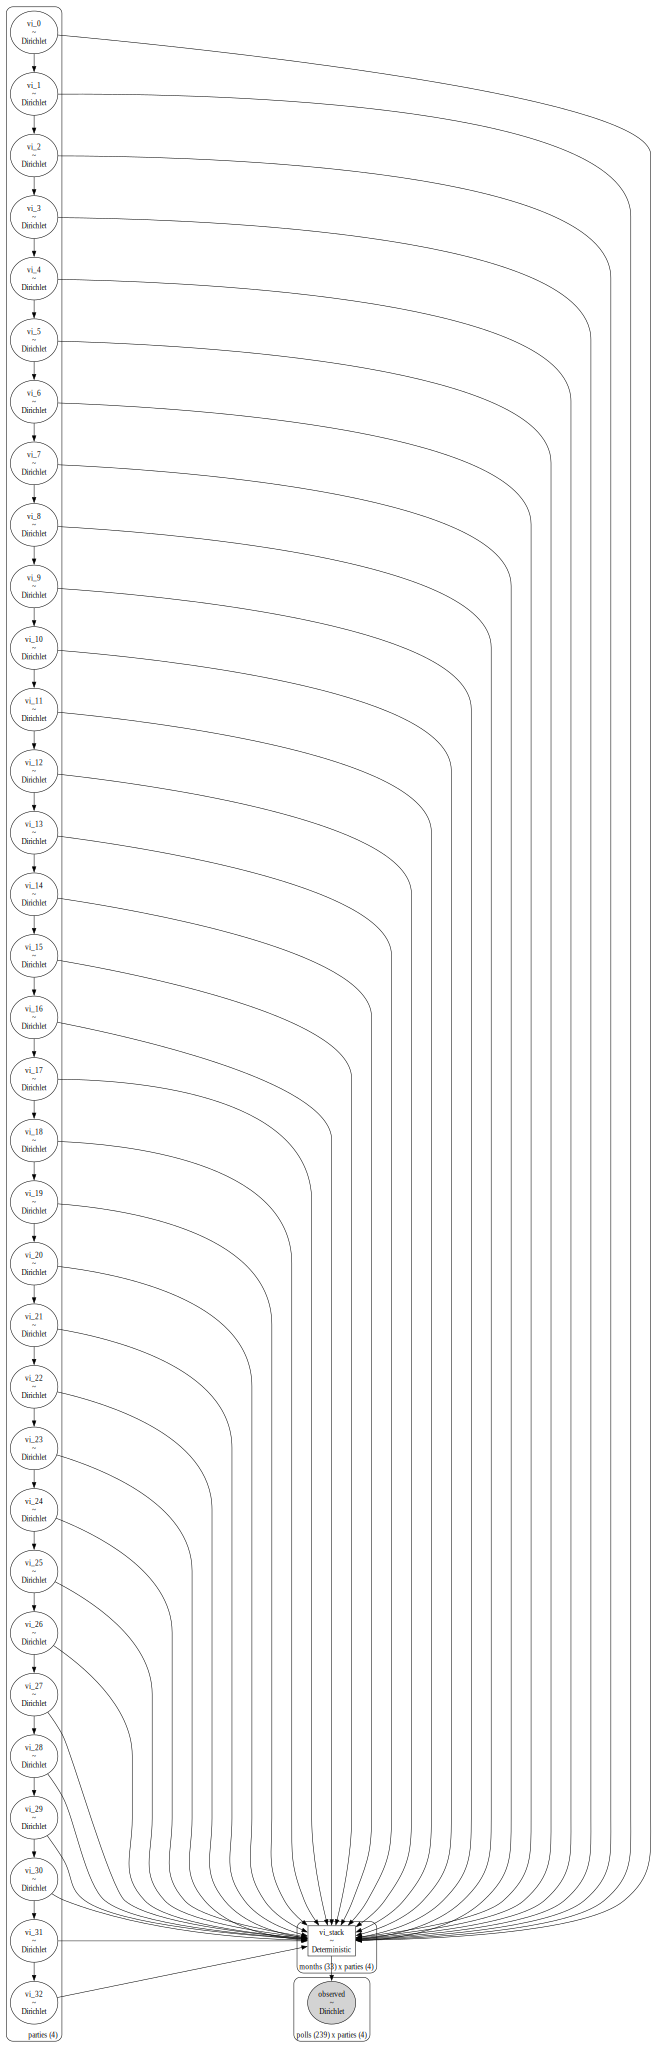

In [8]:
def graph_model(m: pm.Model, do_it: bool = False) -> None:
    """Graph the model."""

    if not do_it:
        return

    bayes_tools.generate_model_map(
        m, "dirichlet_primary_monthly_vi", MODEL_DIR, display_images=True
    )


graph_model(the_model, do_it=True)

## Fit the data to the model

With a relatively loose concentration parameter for polling (say 1_000), and 
a tighter concentration for history (say 5_000), this model takes 
about 5 minutes to run.

Note: some chains run much, much faster than others, but this does not
seem to produce divergences, a low ess or a bad r_hat score.

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/pymc/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(

Max r_hat: 1.0
Min ess: 3776.0
Divergences: 0


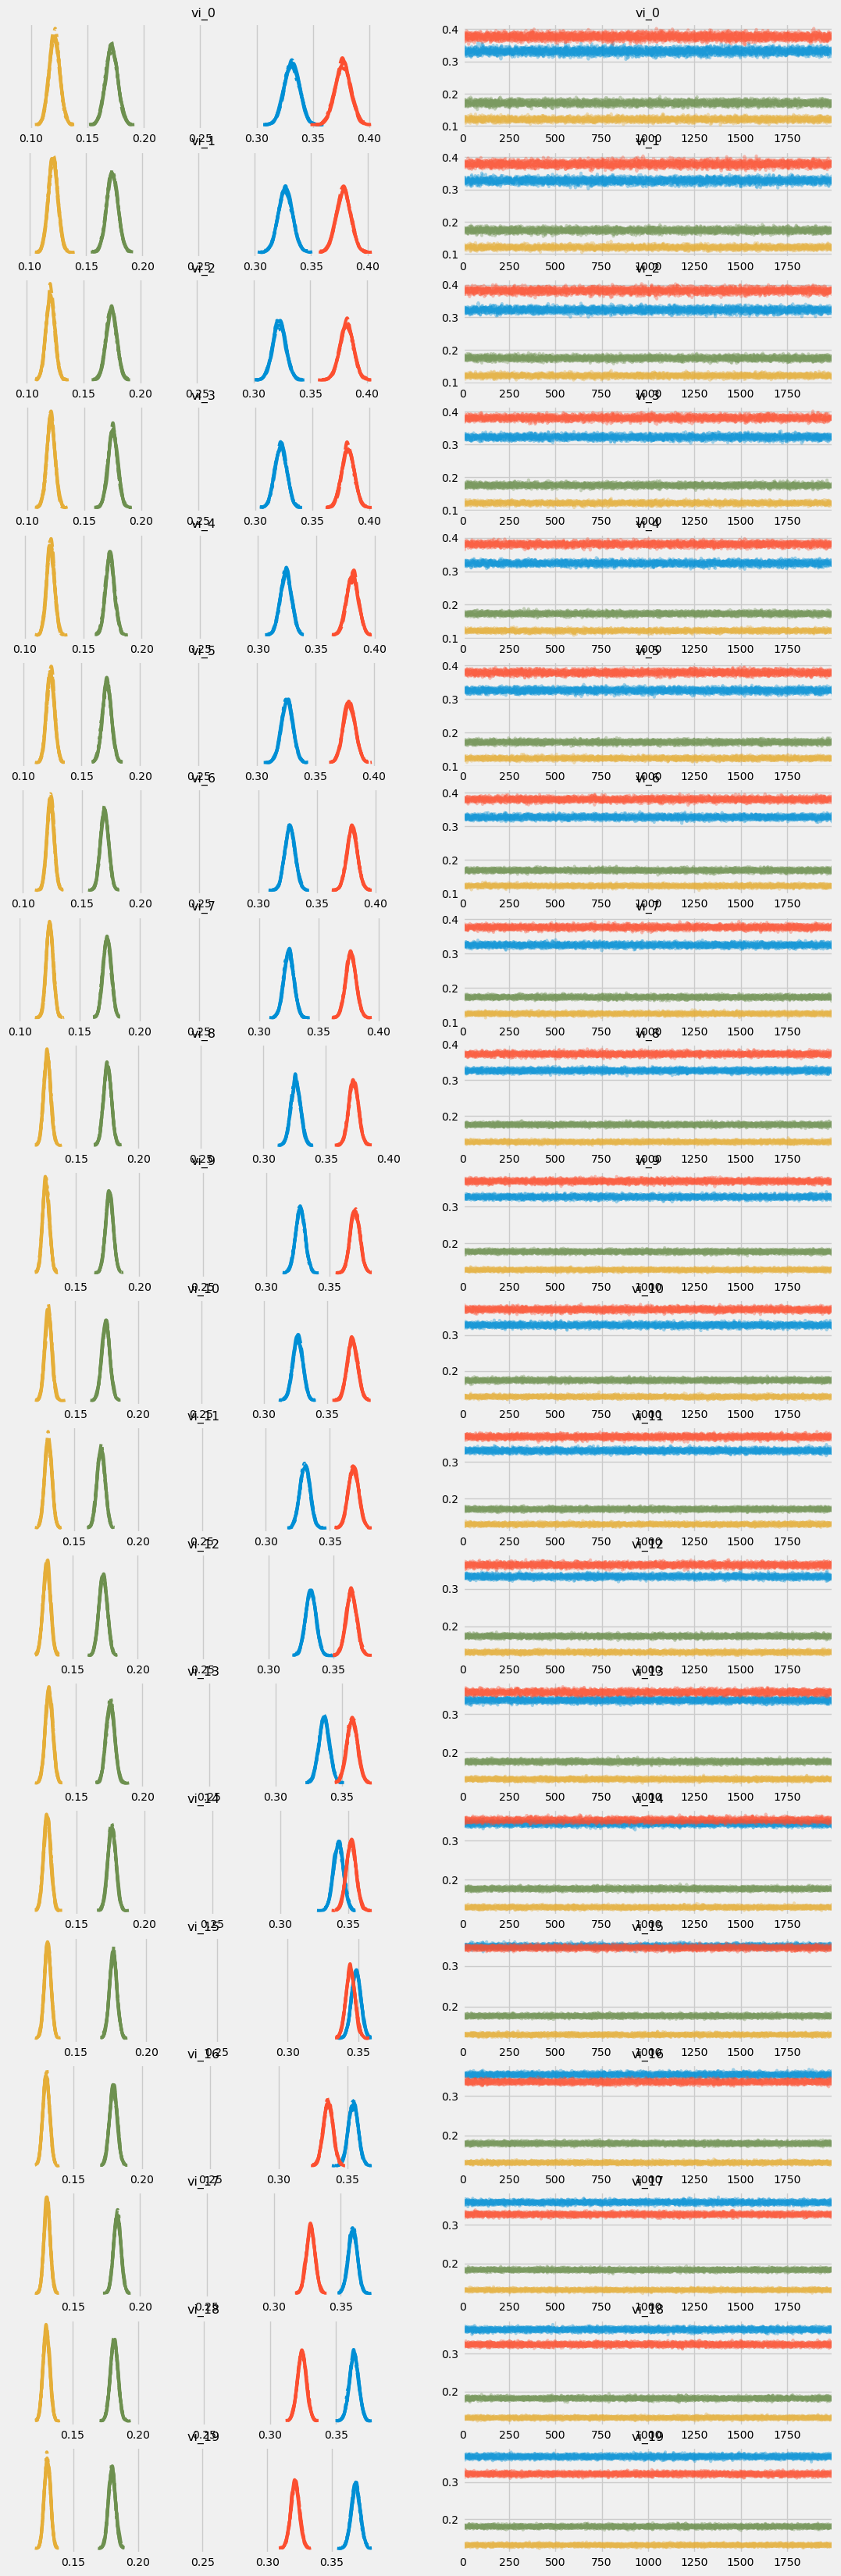

In [9]:
class SampleSettings(TypedDict):
    """The settings for the Bayesian model."""

    draws: int
    tune: int
    cores: int
    chains: int
    nuts_sampler: str
    nuts: NotRequired[dict[str, Any]]  # Requires Python 3.11


def sampler_settings() -> SampleSettings:
    """Return the settings for sampling."""

    core_chains = 5
    settings: SampleSettings = {
        "draws": 2_000,  # number of samples per core
        "tune": 3_000,  # number of tuning steps per core
        "cores": core_chains,
        "chains": core_chains,
        "nuts_sampler": "numpyro",
    }

    return settings


def run_run() -> tuple[az.InferenceData, str]:
    """Fit the data to the model. Return the inference data
    and a string identifying where glitches may have occurred
    in the sampling process."""

    with the_model:
        sampling = sampler_settings()
        idata, glitches = bayes_tools.draw_samples(the_model, **sampling)

    return idata, glitches


inference, problems = run_run()

## Charts

In [10]:
@cache
def _get_var(var_name: str) -> pd.DataFrame:
    """Extract the chains/draws for a specified var_name."""

    return (
        az.extract(inference, var_names=var_name)
        .transpose("sample", ...)
        .to_dataframe()[var_name]
    )



In [11]:
# useful reminder of the index names
data = _get_var("vi_stack")
print(data.index.names)

['chain', 'draw', 'months', 'parties']


All data: (330000, 4)
Coalition (10000, 33)
Labor (10000, 33)
Greens (10000, 33)
Others (10000, 33)


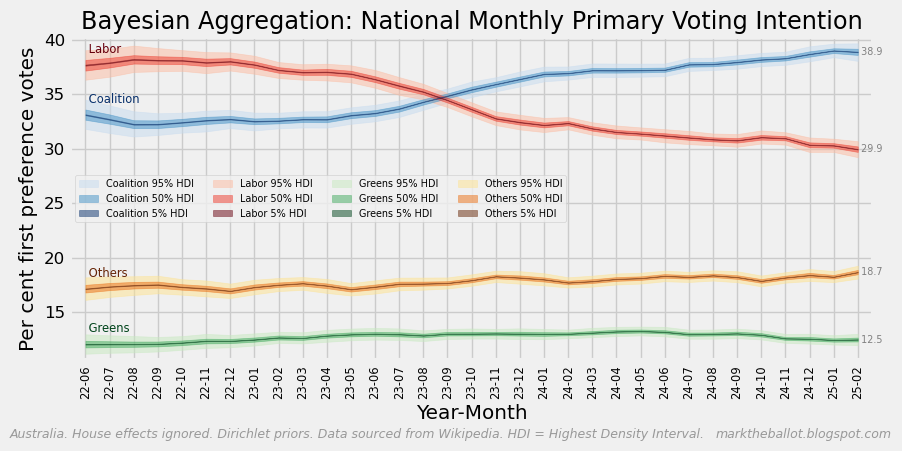

In [12]:
def chart_the_model(inputs: dict[str, Any]) -> None:
    """Chart the model."""

    # basics
    start_month: pd.Period = pd.Period(inputs["simplex_nat_vi"].index.min(), freq="M")
    percents = [2.5, 25, 47.5]
    intensities = [
        (p - min(percents)) / (max(percents) - min(percents)) for p in percents
    ]
    min_intensity = 0.25
    intensity_fracs = [c * (1.0 - min_intensity) + min_intensity for c in intensities]

    # full data extraction
    vi_idata = _get_var("vi_stack").unstack(level="parties")
    print("All data:", vi_idata.shape) # rows are inference data, cols are parties

    # plot
    _fig, ax = plt.subplots()
    medians = {}
    parties = ["Coalition", "Labor", "Greens", "Others"]
    for p, party in enumerate(parties):
        # get the party data
        specific_party_data = vi_idata[vi_idata.columns[p]]
        month_data = specific_party_data.unstack(level="months")
        median = month_data.median(axis=0)
        medians[party] = median
        print(party, month_data.shape)  # rows are inference data, cols are months

        # get the appropriate political party colors
        palette = {
            "Coalition": "Blues",
            "Labor": "Reds",
            "Greens": "Greens",
            "Others": "YlOrBr",
        }[party]
        color = plt.get_cmap(palette)

        for i, pct in enumerate(percents):
            quants = pct, 100 - pct
            label = f"{party} {quants[1] - quants[0]:0.0f}% HDI"

            x, y1, y2 = [], [], []
            for month in month_data.columns:
                period = start_month + int(month)
                vi = month_data[month]

                lower, upper = [vi[p].quantile(q=q / 100.0) for q in quants]
                x.append(str(period)[2:])
                y1.append(lower * 100)
                y2.append(upper * 100)

            intensity = intensity_fracs[i]
            ax.fill_between(
                x=x,  # type: ignore[arg-type]
                y1=y1,
                y2=y2,
                color=color(intensity),
                alpha=0.5,
                label=label,
                zorder=i + 1,
            )
        ax.text(
            x=x[-1],  # type: ignore[arg-type]
            y=y2[-1],
            s=f" {(y2[-1]+y1[-1])/2:.1f}",
            va="center",
            ha="left",
            color="gray",
            fontsize="xx-small",
        )
        ax.text(
            x=x[0],  # type: ignore[arg-type]
            y=y2[0] + 0.8,
            s=f" {party}",
            va="bottom",
            ha="left",
            color=color(intensity_fracs[-1]),
            fontsize="x-small",
        )

    ax.tick_params(axis="x", rotation=90, labelsize="x-small")
    plotting.finalise_plot(
        ax,
        title="Bayesian Aggregation: National Monthly Primary Voting Intention",
        ylabel="Per cent first preference votes",
        xlabel="Year-Month",
        legend={"loc": "center left", "fontsize": "xx-small", "ncol": 4},
        lfooter="Australia. House effects ignored. Dirichlet priors. "
        + "Data sourced from Wikipedia. HDI = Highest Density Interval.",
        rfooter="marktheballot.blogspot.com",
        rheader=problems if problems else None,
        show=True,
    )

    # save the medians for subsequent analysis
    mdf = pd.DataFrame(medians)
    mdf.index = pd.PeriodIndex(start_month + mdf.index, freq="M")
    mdf.to_csv(NAT_MON_DIRICHLET_MEDIANS)


chart_the_model(P)

## Finished

In [13]:
print("Finished")

Finished
